
# ROAD IMAGE SEGMENTATION <br>
## Mini Project 3 - Visual Computing Lab
<br>
Name: Haardik Ravat<br>
Roll No.: B20EE021

## Libraries

In [ ]:
import os
import cv2
import glob
import torch
import tqdm
import datetime
import numpy as np
from PIL import Image
import torch.nn as nn
import albumentations as A
from torch import from_numpy
import torch.nn.functional as F
from torch.nn import DataParallel
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader

## Parameters

In [ ]:
INPUT_IMG_SIZE = 128

OUTPUT_CLASSES = 12

LEARINING_RATE = 0.01

OPIMIZER_NAME = 'Adam'

SCHEDULER_NAME = 'stepLR'

BATCH_SIZE = 8

MAX_EPOCHS = 10

AUGMENTATION = False

MEAN = None

STD = None

THRESH_ACC_CKP = 0.9

SCHEDULER_STEP_SIZE = 4

USE_CUDA = torch.cuda.is_available()

INPUT_PATH = './segdata128/reduced'

INPUT_PATH_MASK = './segdata128/reduced_mask'

## Importing and Analysing Dataset

In [ ]:
!gdown -O cityscape128.zip "https://drive.google.com/u/0/uc?id=1XUWaL2ijz1vjbKbxJ6TYkG4QZgIsiZu_&export=download"

Downloading...
From: https://drive.google.com/u/0/uc?id=1XUWaL2ijz1vjbKbxJ6TYkG4QZgIsiZu_&export=download
To: /content/cityscape128.zip
100% 50.1M/50.1M [00:01<00:00, 43.2MB/s]


In [ ]:
!unzip cityscape128.zip

Streaming output truncated to the last 5000 lines.
  inflating: segdata128/reduced_mask/train/1114.jpg  
  inflating: segdata128/reduced_mask/train/294.jpg  
  inflating: segdata128/reduced_mask/train/886.jpg  
  inflating: segdata128/reduced_mask/train/1816.jpg  
  inflating: segdata128/reduced_mask/train/1187.jpg  
  inflating: segdata128/reduced_mask/train/1723.jpg  
  inflating: segdata128/reduced_mask/train/312.jpg  
  inflating: segdata128/reduced_mask/train/2565.jpg  
  inflating: segdata128/reduced_mask/train/1232.jpg  
  inflating: segdata128/reduced_mask/train/2628.jpg  
  inflating: segdata128/reduced_mask/train/2630.jpg  
  inflating: segdata128/reduced_mask/train/2744.jpg  
  inflating: segdata128/reduced_mask/train/1149.jpg  
  inflating: segdata128/reduced_mask/train/1026.jpg  
  inflating: segdata128/reduced_mask/train/1354.jpg  
  inflating: segdata128/reduced_mask/train/989.jpg  
  inflating: segdata128/reduced_mask/train/487.jpg  
  inflating: segdata128/reduced_mask

In [ ]:
train_files = glob.glob(os.path.join(INPUT_PATH + '/train', '*jpg'))
train_files_mask = glob.glob(os.path.join(INPUT_PATH_MASK + '/train', '*jpg'))
test_files = glob.glob(os.path.join(INPUT_PATH + '/val', '*jpg'))
test_files_mask = glob.glob(os.path.join(INPUT_PATH_MASK + '/val', '*jpg'))


In [ ]:
print('Total train images:', len(train_files))
print('Total train mask:', len(train_files_mask))

print('Total test images:', len(test_files))
print('Total test mask:', len(test_files_mask))

Total train images: 2975
Total train mask: 2975
Total test images: 500
Total test mask: 500


In [ ]:
train_files_length = len(train_files)
train_mask_length = len(train_files_mask)
test_files_length = len(test_files)
test_mask_length = len(test_files_mask)

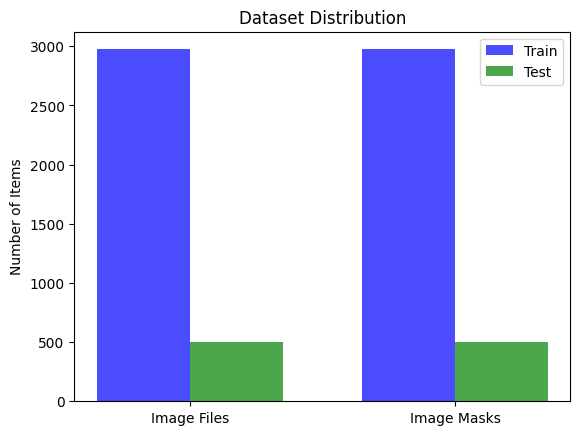

In [ ]:
keys = ['Image Files', 'Image Masks']
train_values = [train_files_length, train_mask_length]
test_values = [test_files_length, test_mask_length]

bar_width = 0.35
index = range(len(keys))

plt.bar(index, train_values, bar_width, label='Train', alpha=0.7, color='b', align='center')
plt.bar([i + bar_width for i in index], test_values, bar_width, label='Test', alpha=0.7, color='g', align='center')

plt.ylabel('Number of Items')
plt.title('Dataset Distribution')
plt.xticks([i + bar_width/2 for i in index], keys)
plt.legend()

plt.show()


## Kmeans Clustering

In [ ]:
kmeans_data = []
for i in train_files_mask[:100]:
    org_img = cv2.imread(i)

    msk = org_img
    kmeans_data.append(msk)
kmeans_data = np.array(kmeans_data)
kmeans_data = kmeans_data.reshape(-1,3)
print(kmeans_data.shape)

(1638400, 3)


In [ ]:
encoder = KMeans(n_clusters=OUTPUT_CLASSES)
encoder.fit(kmeans_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=12)

In [ ]:
colors = {0:[ 42.31849768, 138.68802268, 107.34976084],
       1:[127.04043101,  64.08636608, 127.54335584],
       2:[ 67.73835184,  70.81071668,  69.68390725],
       3:[ 77.50990865,  18.95552339,  73.79703489],
       4:[133.96612288,   3.85362098,   4.37284647],
       5:[217.97385828,  43.76697629, 229.43543734],
       6:[164.94309451, 125.22840326,  81.50394562],
       7:[157.10134385, 155.26893603, 193.22678809],
       8:[ 66.53429189,  32.62107138, 188.45387454],
       9:[157.58165138, 243.49941618, 159.97381151],
       10:[  6.98127537,   5.22420501,   6.82420501],
       11:[ 48.88183862, 203.80514614, 203.66699975]
          }

In [ ]:
encoder.cluster_centers_

array([[132.991797  ,   2.85890666,   5.57604622],
       [127.47842043,  63.16100407, 127.8695147 ],
       [ 38.97438253, 138.91834323, 106.86510719],
       [ 68.6413016 ,  67.34103622,  69.51058869],
       [219.41385189,  42.55611348, 231.16160096],
       [  7.30007637,   5.19610495,   7.41967255],
       [159.82960491, 239.00369836, 163.03626195],
       [165.58567737, 159.55605079, 214.70384659],
       [170.06854585, 126.62464271,  77.58322397],
       [ 63.46925805,  29.51024732, 177.75719615],
       [ 99.08555179, 120.21964344, 125.45836159],
       [ 52.19532468, 198.83454545, 205.30363636]])

## Visualizing dataset

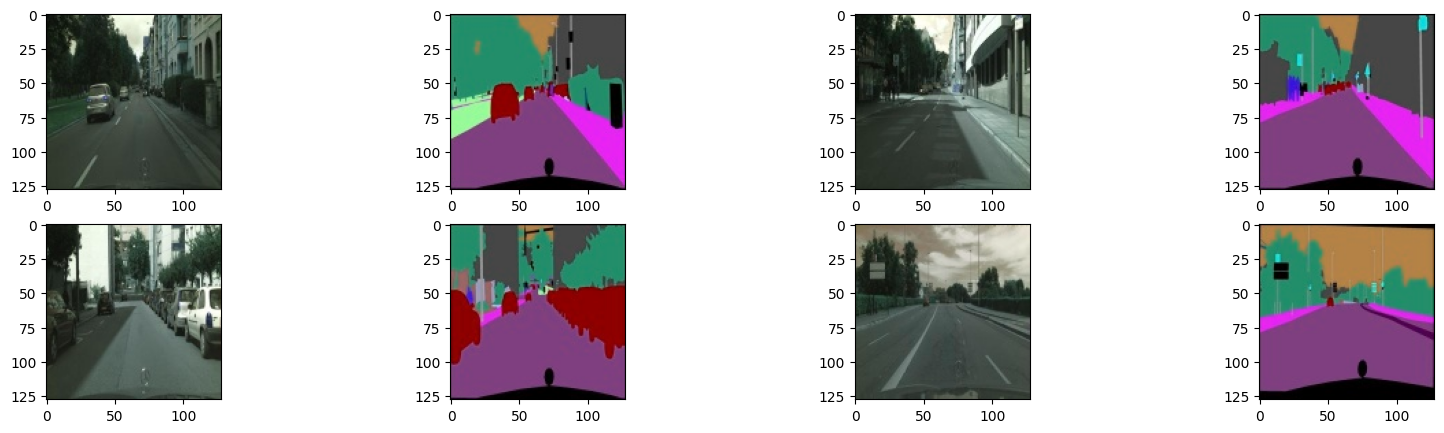

In [ ]:
fig, axes = plt.subplots(2,4, figsize = (20,5))
for i, ax in enumerate(axes.ravel()):
    if(i%2==0):
      img = cv2.imread(train_files[i//2])
      ax.imshow(img)
    else:
      mk = cv2.imread(train_files_mask[i//2])
      ax.imshow(mk)
    # break
    #ax.axis('off')
plt.show()

No of classes in encoded mask: [ 0  1  2  3  4  5  6  7  8  9 10 11]


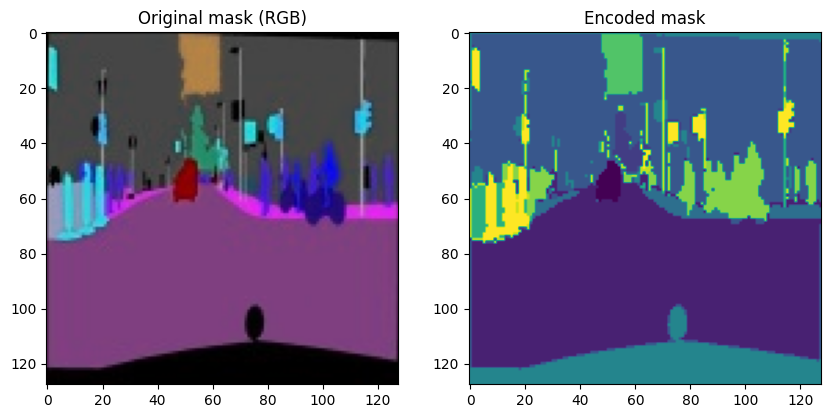

No of classes in encoded mask: [ 0  1  2  3  4  5  6  7  8  9 10 11]


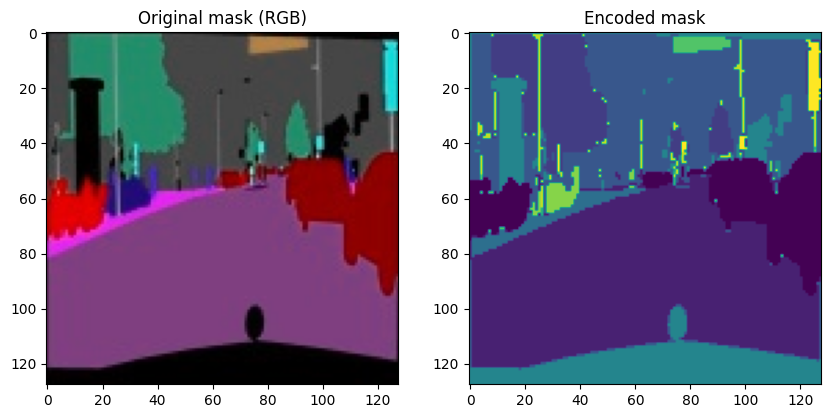

No of classes in encoded mask: [ 0  1  2  3  5  6  7  8  9 10 11]


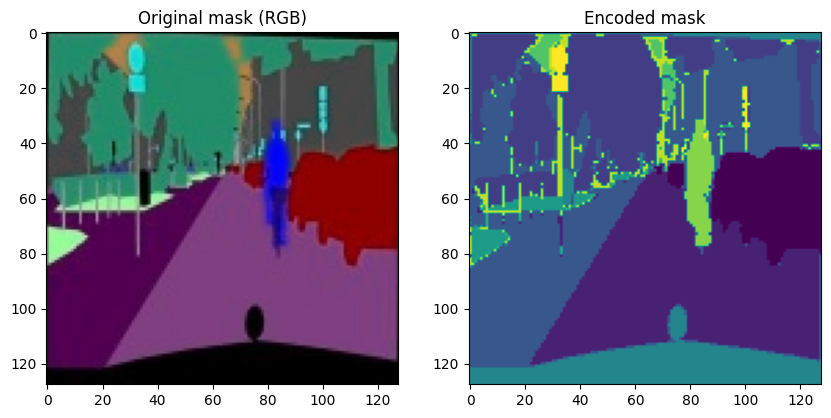

No of classes in encoded mask: [ 0  1  2  3  4  5  6  7  8  9 10 11]


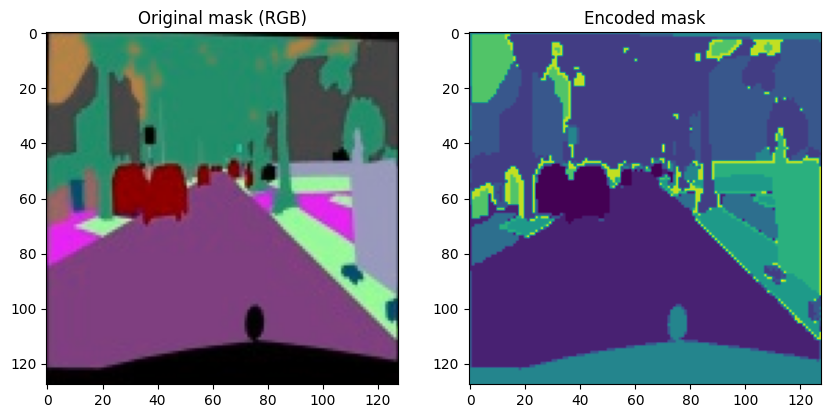

No of classes in encoded mask: [ 0  1  2  3  4  5  7  8  9 10 11]


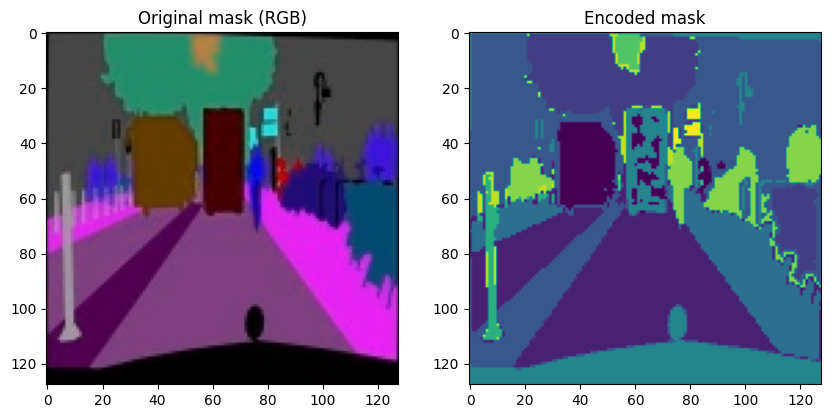

No of classes in encoded mask: [ 0  1  2  3  4  5  7  8  9 10 11]


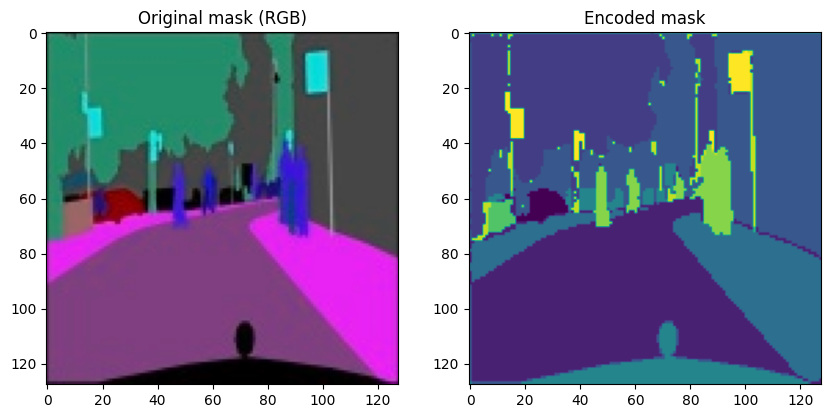

No of classes in encoded mask: [ 0  1  2  3  4  5  6  7  8  9 10 11]


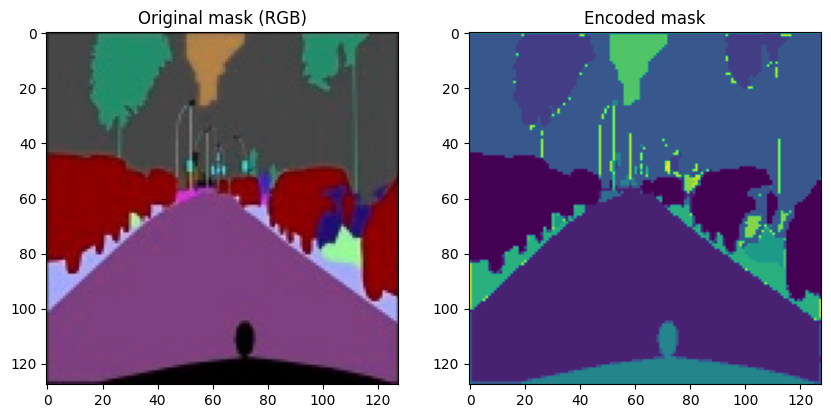

No of classes in encoded mask: [ 0  1  2  3  4  5  6  8 10 11]


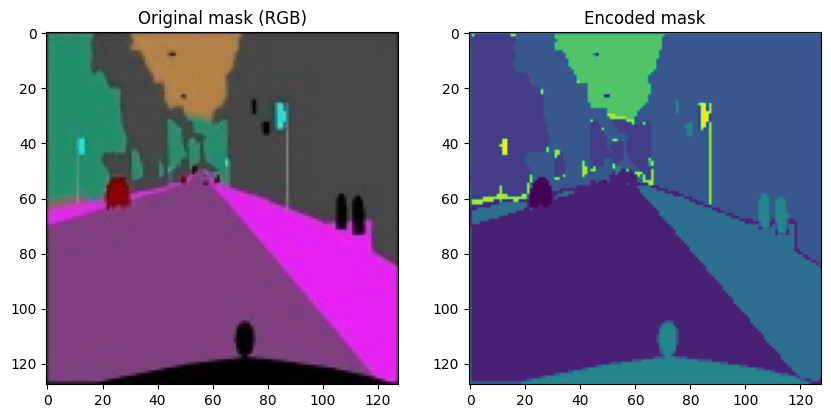

No of classes in encoded mask: [ 0  1  2  3  4  5  7  8  9 10 11]


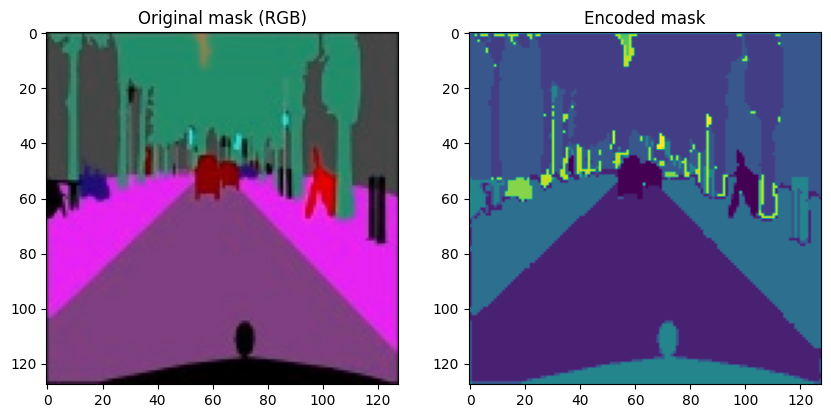

No of classes in encoded mask: [ 0  1  2  3  5  8  9 10]


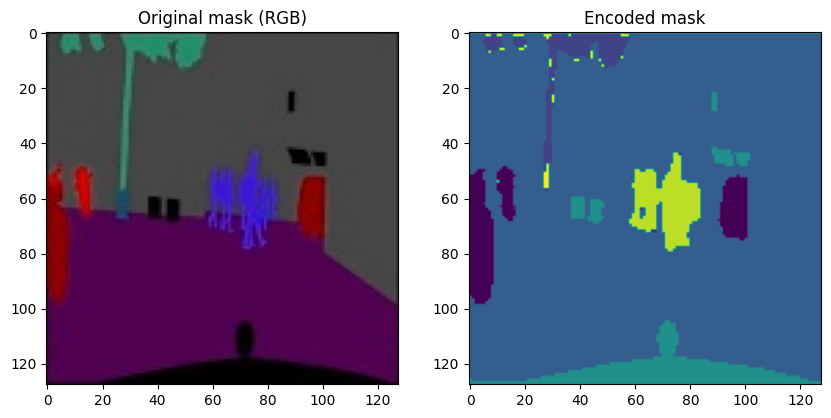

In [ ]:
for i in train_files[300:310]:
    org_img = cv2.imread(i)
    #img = org_img[:, 0:256,:]
    msk = cv2.imread(i.replace("reduced","reduced_mask"))#org_img[:, 256:,:]      #shape (256,256,3)
    test = msk.reshape(-1,3)      #shape (65536,3)
    pred = encoder.predict(test)  #shape (65536)

    enc_pred = pred.reshape(INPUT_IMG_SIZE,INPUT_IMG_SIZE)  #shape (256,256)

    pred = np.array([colors[p] for p in pred]).reshape(INPUT_IMG_SIZE,INPUT_IMG_SIZE,3)

    print('No of classes in encoded mask:',np.unique(enc_pred))

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(msk)
    plt.title('Original mask (RGB)')
    plt.subplot(1,2,2)
    plt.imshow(enc_pred)
    plt.title('Encoded mask')
    plt.show()

## Defining Dataset Objects

### Original Dataset

In [ ]:
class Dataset(Dataset):
    def __init__(self, images_list,mask_list, size, augmentation = False, mean = None, std = None):
        self.images_list = images_list
        self.mask_list = mask_list
        self.size = size
        self.augmentation = augmentation
        if mean is None or std is None:
            self.mean = [0., 0., 0.]
            self.std = [1., 1., 1.]
        else:
            self.mean = mean
            self.std = std

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        pil_image = Image.open(self.images_list[index]).convert('RGB')
        pil_mask = Image.open(self.mask_list[index]).convert('RGB')



        np_image = np.array(pil_image)
        np_target = np.array(pil_mask)


        test = (np_target.reshape(-1,3))
        pred = encoder.predict(test)
        seg_msk = pred.reshape(self.size,self.size)
        angle=np.random.randint(25)
        if self.augmentation:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                           A.Rotate(angle, border_mode=4, p=0.5),
                           A.HorizontalFlip(p=0.3),
                           A.VerticalFlip(p=0.3),
                           A.OneOf([A.OpticalDistortion(),A.ElasticTransform()],  p=0.4),
                           A.CoarseDropout(max_holes=30, max_height=int(self.size*0.015),
                                         max_width=int(self.size*0.015), fill_value=255, p=0.4),
                           A.RandomBrightnessContrast(brightness_limit=0.3,p = 0.4),
                           A.RandomSnow(snow_point_lower=0.4,snow_point_upper=0.5,brightness_coeff=1.5,p = 0.4),
                           A.Normalize(self.mean, self.std)
                          ])
        else:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                                   A.Normalize(self.mean, self.std)])

        transformed = trans_obj(image = np_image, mask = seg_msk)
        img_tensor = from_numpy(transformed['image']).permute(2, 0, 1)
        mask_tensor = from_numpy(transformed['mask'])
        return img_tensor, mask_tensor


In [ ]:
train_data_obj = Dataset(train_files,train_files_mask, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)
val_data_obj = Dataset(test_files, test_files_mask, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)

In [ ]:
print(train_data_obj.__len__())
print(val_data_obj.__len__())

2975
500


In [ ]:
for i in range(5):
    img,  msk = train_data_obj.__getitem__(i)
    print(img.shape, msk.shape)
    print(img.max(), img.min())
    print(msk.max(), msk.min())
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img.permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(msk)
    plt.show()

### Augmented Datasets

In [ ]:
class Dataset_aug(Dataset):
    def __init__(self, images_list,mask_list, size, augmentation = False, mean = None, std = None):
        self.images_list = images_list
        self.mask_list = mask_list
        self.size = size
        self.augmentation = augmentation
        if mean is None or std is None:
            self.mean = [0., 0., 0.]
            self.std = [1., 1., 1.]
        else:
            self.mean = mean
            self.std = std

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        pil_image = Image.open(self.images_list[index]).convert('RGB')
        pil_mask = Image.open(self.mask_list[index]).convert('RGB')



        np_image = np.array(pil_image)
        np_target = np.array(pil_mask)


        test = (np_target.reshape(-1,3))
        pred = encoder.predict(test)
        seg_msk = pred.reshape(self.size,self.size)

        if self.augmentation:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                           A.Rotate(10, border_mode=4, p=0.5),
                           A.HorizontalFlip(p=0.3),
                           A.VerticalFlip(p=0.3),
                           A.OneOf([A.OpticalDistortion(),A.ElasticTransform()],  p=0.4),
                           A.CoarseDropout(max_holes=30, max_height=int(self.size*0.015),
                                         max_width=int(self.size*0.015), fill_value=255, p=0.4),
                           A.RandomBrightnessContrast(brightness_limit=0.3,p = 0.4),
                           A.RandomSnow(snow_point_lower=0.4,snow_point_upper=0.5,brightness_coeff=1.5,p = 0.4),
                           A.Normalize(self.mean, self.std)
                          ])
        else:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                                   A.Normalize(self.mean, self.std)])

        transformed = trans_obj(image = np_image, mask = seg_msk)
        img_tensor = from_numpy(transformed['image']).permute(2, 0, 1)
        mask_tensor = from_numpy(transformed['mask'])
        return img_tensor, mask_tensor


In [ ]:
train_data_aug = Dataset_aug(train_files,train_files_mask, INPUT_IMG_SIZE, True, mean=MEAN, std=STD)
val_data_aug = Dataset_aug(test_files, test_files_mask, INPUT_IMG_SIZE, True, mean=MEAN, std=STD)

In [ ]:
print(train_data_aug.__len__())
print(val_data_aug.__len__())

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(0.8353) tensor(0.0235)
tensor(10, dtype=torch.int32) tensor(1, dtype=torch.int32)


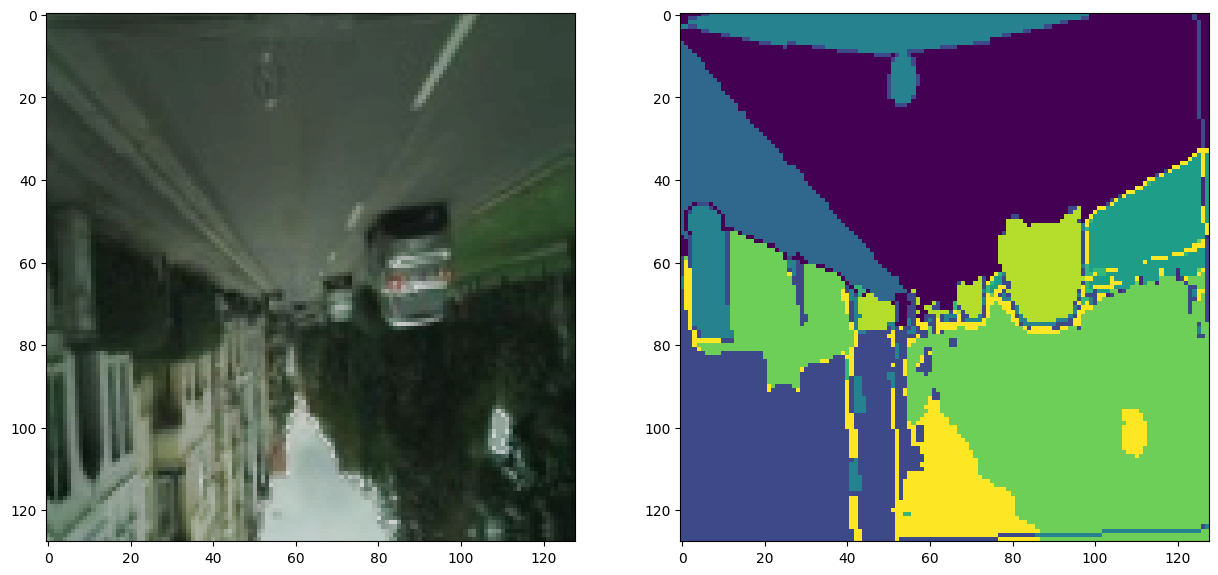

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(0.7882) tensor(0.)
tensor(10, dtype=torch.int32) tensor(0, dtype=torch.int32)


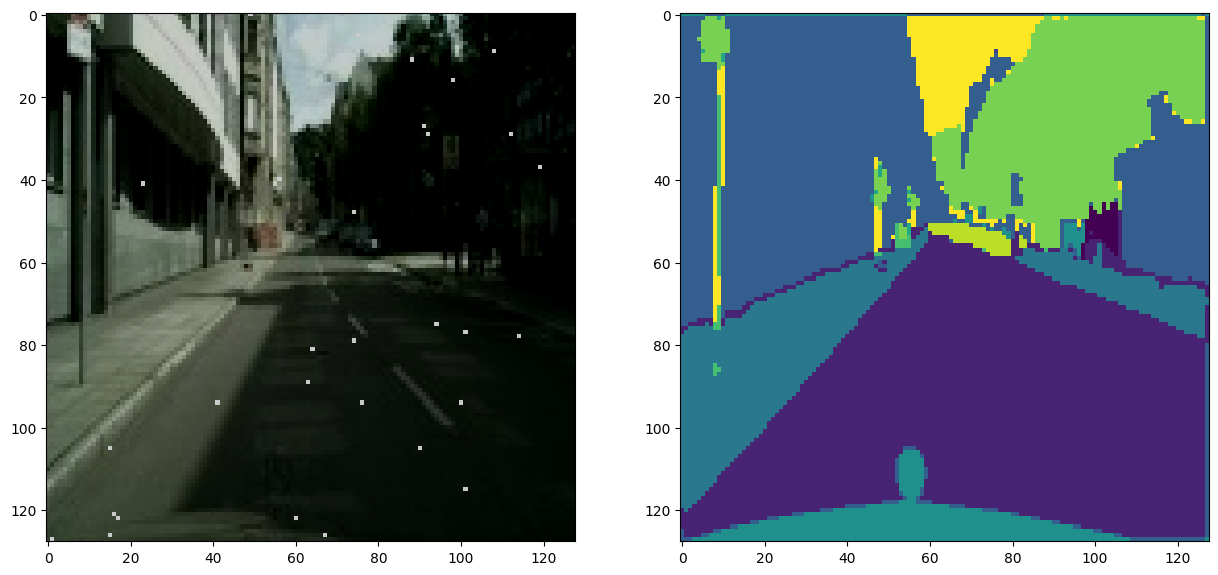

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.0314)
tensor(10, dtype=torch.int32) tensor(0, dtype=torch.int32)


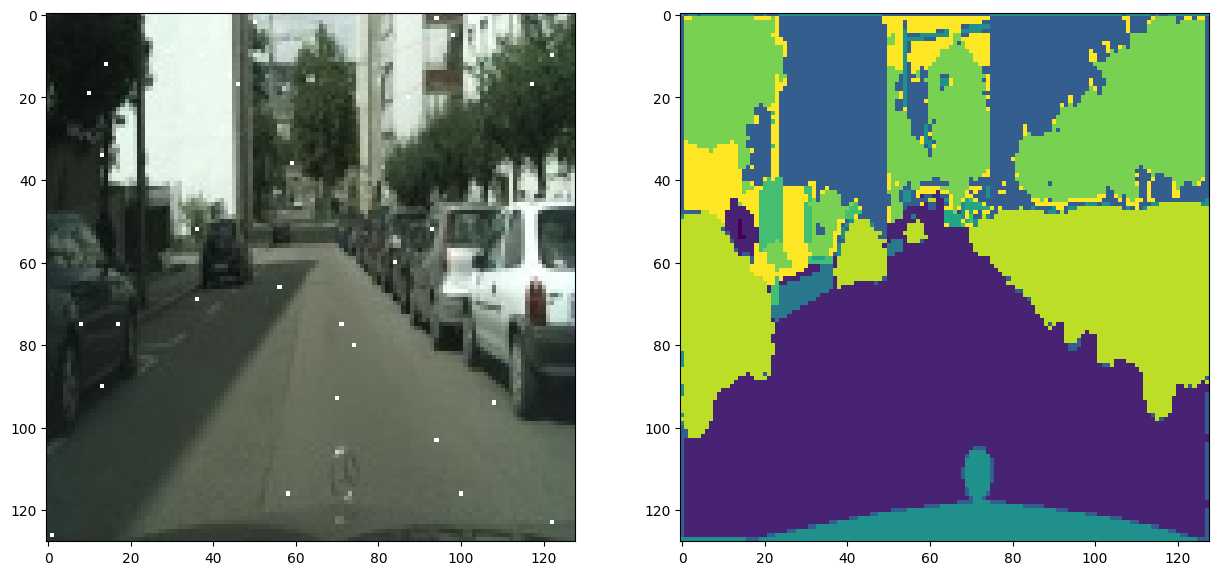

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(0.9294) tensor(0.0353)
tensor(11, dtype=torch.int32) tensor(1, dtype=torch.int32)


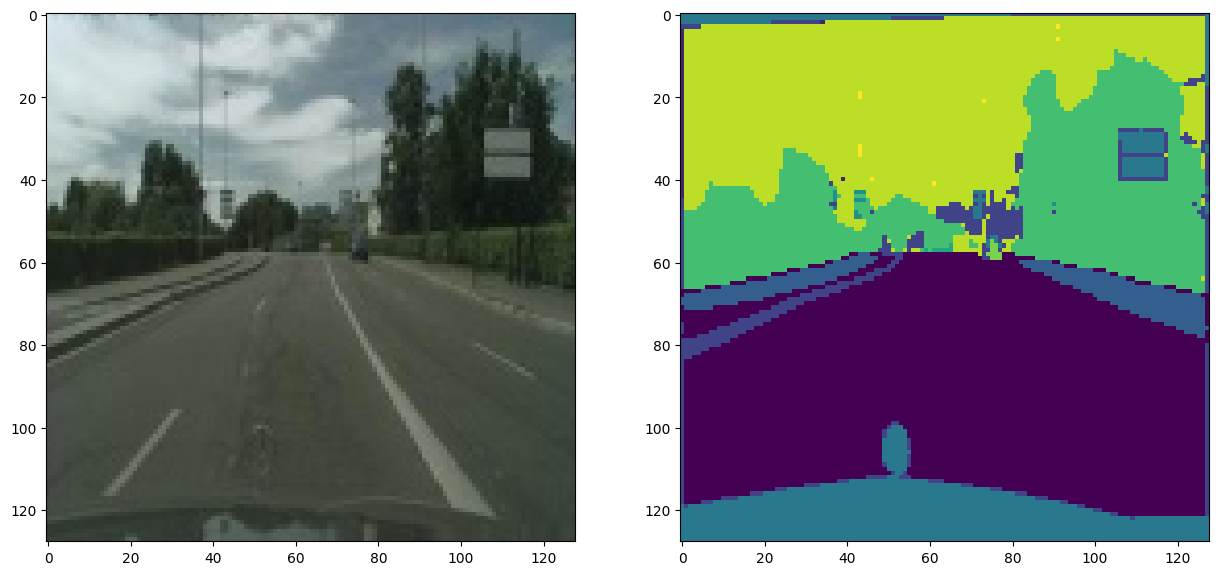

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(0.5765) tensor(0.)
tensor(10, dtype=torch.int32) tensor(0, dtype=torch.int32)


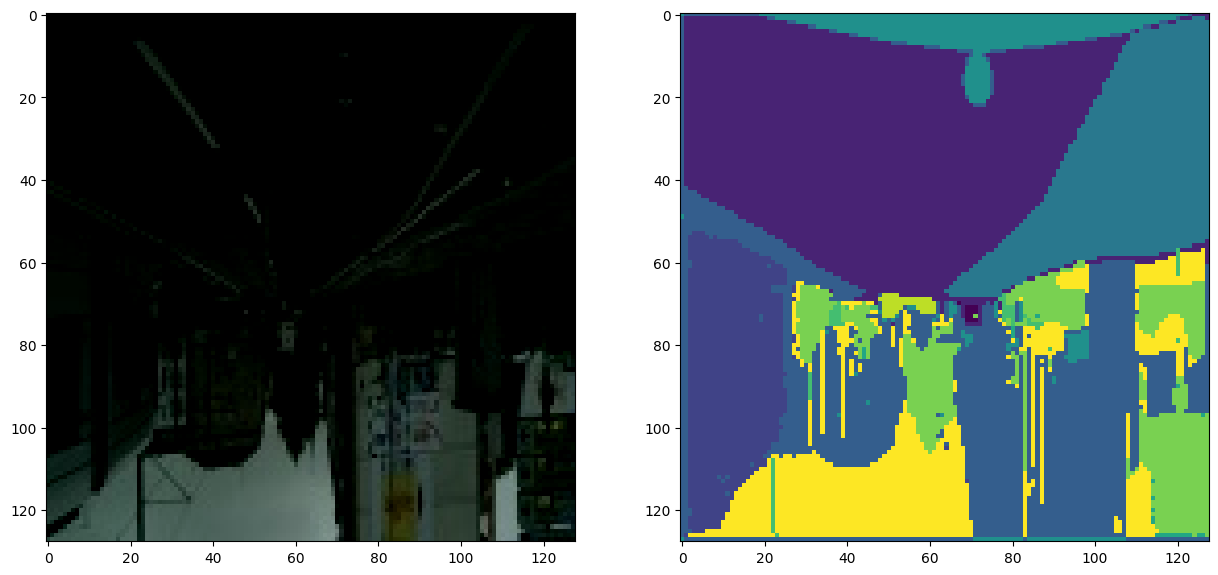

In [ ]:
for i in range(5):
    img,  msk = train_data_aug.__getitem__(i)
    print(img.shape, msk.shape)
    print(img.max(), img.min())
    print(msk.max(), msk.min())
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img.permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(msk)
    plt.show()

## Trainer

In [ ]:
class Trainer:
    def __init__(self,
                 model,
                 crit,
                 train_data = None,
                 val_data = None,
                 initialize_from_ckp = None,
                 opti_name = None,
                 scheduler_name = None,
                 input_img_size = None,
                 batch_size = None,
                 out_classes = None,
                 use_cuda = False,
                 max_epochs = None,
                 learning_rate = None,
                 thresh_acc = None,
                 experiment_name = None,
                 step_size = None
                 ):
        self.model = model
        self.crit = crit
        self.train_data = train_data
        self.val_data = val_data
        self.opti_name = opti_name
        self.scheduler_name = scheduler_name
        self.input_img_size = input_img_size
        self.batch_size = batch_size
        self.out_classes = out_classes
        self.cuda = use_cuda
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.thresh_acc_ckp = thresh_acc
        self.step_size = step_size

        if use_cuda:
            self.model = model.cuda()
            self.crit = crit.cuda()
            self.model = DataParallel(model)

        self.optim = self.select_optimizer()
        self.scheduler = self.select_scheduler()
        self.train_dl = self.data_loader(self.train_data)
        self.val_test_dl = self.data_loader(self.val_data)
        self.nowtime = datetime.datetime.now().strftime('%d-%m-%Y [%H.%M.%S]')

        if initialize_from_ckp is not None:
            self.restore_checkpoint(initialize_from_ckp)

    def data_loader(self, data_object):
        return DataLoader(data_object, batch_size = self.batch_size, shuffle=True)

    def select_optimizer(self):
        if self.opti_name == 'Adam':
            return Adam(self.model.parameters(), lr=self.learning_rate)
        if self.opti_name == 'SGD':
            return SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9)

    def select_scheduler(self):
        if self.scheduler_name == 'stepLR':
            return lr_scheduler.StepLR(optimizer=self.optim, step_size = self.step_size, gamma=0.1)
        if self.scheduler_name == 'ReduceLROnPlateau':
            return lr_scheduler.ReduceLROnPlateau(optimizer = self.optim, mode='max', factor=0.2)

    def restore_checkpoint(self, checkpoint):
        cuda_device = torch.device('cuda' if self.cuda else 'cpu')
        ckp = torch.load(checkpoint, map_location = cuda_device)
        self.model.load_state_dict(ckp)
        for param in self.model.features.parameters():
            param.requires_grad = False
        # self._optim.load_state_dict(ckp)

    def save_checkpoint(self, folder_name):
        torch.save({'state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optim.state_dict(),
                }, folder_name + '/checkpoint.ckp')

    def IoU(self, label, pred, num_classes=12):
        label = label.detach().cpu()
        pred = pred.detach().cpu()
        pred = F.softmax(pred, dim=1)
        pred = torch.argmax(pred, dim=1).squeeze(1)
        iou_list = list()
        present_iou_list = list()

        pred = pred.view(-1)
        label = label.view(-1)

        for sem_class in range(num_classes):
            pred_inds = (pred == sem_class)
            target_inds = (label == sem_class)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else:
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list.append(iou_now)
            iou_list.append(iou_now)
        return np.mean(present_iou_list)

    def train_epoch(self):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.train()
        loss_list = []
        acc_list = []

        for i, (images, labels) in enumerate(self.train_dl):
            batchsize = images.shape[0]
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)
            self.optim.zero_grad()
            preds = self.model(images)
            loss = self.crit(preds, labels.long())
            accuracy = self.IoU(labels, preds)
            #print(accuracy)
            loss.backward()
            self.optim.step()
            lossitem = loss.item()
            del loss
            loss_list.append(lossitem)
            acc_list.append(accuracy)

        loss_avg = np.mean(loss_list)
        acc_avg = np.mean(acc_list)
        return loss_avg, acc_avg

    def val_epoch(self, current_epoch):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.eval()
        loss_list = []
        acc_list = []
        with torch.no_grad():
            for i, (images, labels) in enumerate(self.val_test_dl):
                im, lb = images, labels
                batchsize = images.shape[0]
                images = images.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                preds = self.model(images)
                loss = self.crit(preds, labels.long())
                lossitem = loss.item()
                del loss

                accuracy = self.IoU(labels, preds)
                loss_list.append(lossitem)
                acc_list.append(accuracy)
                if i == 2:
                    print('-'*20)
                    print('Validation results after {} epochs:'.format(current_epoch))
                    plt.figure(figsize=(20,15))
                    plt.subplot(1,3,1)
                    plt.imshow(im[0].permute(1,2,0))
                    plt.title('image')
                    plt.subplot(1,3,2)
                    plt.imshow(lb[0])
                    plt.title('mask')
                    plt.subplot(1,3,3)
                    p = preds[0].permute(1,2,0)
                    p = torch.argmax(p, dim=2)
                    plt.imshow(p.cpu())
                    plt.title('prediction')
                    plt.show()
            loss_avg = np.mean(loss_list)
            acc_avg = np.mean(acc_list)
        return loss_avg, acc_avg

    def print_train_logs(self, results):
        epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy = results
        print('[Epochs-{}/{}]:'. format(epoch_counter, self.max_epochs))
        print('[Train_loss:{:0.4f} | Train_acc:{:0.4f} | Val_loss:{:0.4f} | Val_acc:{:0.4f}]'
                  .format(train_loss, train_accuracy, val_loss, val_accuracy))

    def plot_logs(self, results):
        epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy = results


        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epoch_counter, train_accuracy, label='Train Accuracy', color='blue')
        plt.plot(epoch_counter, val_accuracy, label='Validation Accuracy', color='red')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()


        plt.subplot(1, 2, 2)
        plt.plot(epoch_counter, train_loss, label='Train Loss', color='green')
        plt.plot(epoch_counter, val_loss, label='Validation Loss', color='orange')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

    def train(self):

        model_path = 'results/%s' % (self.nowtime)
        epoch_counter_list = []
        train_loss_list = []
        train_accuracy_list = []
        val_loss_list = []
        val_accuracy_list = []

        for epoch_counter in tqdm.tqdm(range(1, self.max_epochs+1)):
            train_loss, train_accuracy = self.train_epoch()
            val_loss, val_accuracy= self.val_epoch(epoch_counter)
            epoch_counter_list.append(epoch_counter)
            train_loss_list.append(train_loss)
            train_accuracy_list.append(train_accuracy)
            val_loss_list.append(val_loss)
            val_accuracy_list.append(val_accuracy)
            epoch_results = [epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy]
            self.print_train_logs(epoch_results)

            if val_accuracy > self.thresh_acc_ckp and val_accuracy == max(val_accuracy_list):
                new_ckp = '/epoch_{}_val_acc [{:0.3f}]' . format(epoch_counter, val_accuracy)
                temp_path = model_path + new_ckp
                os.makedirs(temp_path, exist_ok=True)
                if os.path.exists(temp_path):
                    self.save_checkpoint(temp_path)

            if self.scheduler:
                self.scheduler.step()
        train_results = [epoch_counter_list, train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list]
        self.plot_logs(train_results)

## Defining Model

### Initializing

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=256, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)




    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):

        contracting_11_out = self.contracting_11(X)

        contracting_12_out = self.contracting_12(contracting_11_out)

        contracting_21_out = self.contracting_21(contracting_12_out)

        contracting_22_out = self.contracting_22(contracting_21_out)

        contracting_31_out = self.contracting_31(contracting_22_out)

        contracting_32_out = self.contracting_32(contracting_31_out)

        middle_out = self.middle(contracting_32_out)

        expansive_11_out = self.expansive_11(middle_out)

        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_31_out), dim=1))

        expansive_21_out = self.expansive_21(expansive_12_out)

        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_21_out), dim=1))

        expansive_31_out = self.expansive_31(expansive_22_out)

        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_11_out), dim=1))

        output_out = self.output(expansive_32_out)
        return output_out

In [ ]:
nt = Net(12)

In [ ]:
nt(torch.zeros(2,3,128,128)).shape

torch.Size([2, 12, 128, 128])

### Training

In [ ]:
unet = Net(num_classes=OUTPUT_CLASSES)

In [ ]:
model = unet
loss_function = nn.CrossEntropyLoss()

In [ ]:
trainer =  Trainer(model = model,
                  crit = loss_function,
                  train_data = train_data_aug,
                  val_data = val_data_aug,
                  initialize_from_ckp = None,
                  opti_name = OPIMIZER_NAME,
                  scheduler_name = SCHEDULER_NAME,
                  input_img_size = INPUT_IMG_SIZE,
                  batch_size = BATCH_SIZE,
                  out_classes = OUTPUT_CLASSES,
                  use_cuda = USE_CUDA,
                  # max_epochs = MAX_EPOCHS,
                   max_epochs = 2,
                  learning_rate = LEARINING_RATE,
                  thresh_acc = THRESH_ACC_CKP,
                  step_size = SCHEDULER_STEP_SIZE
                 )

  0%|          | 0/3 [00:00<?, ?it/s]

--------------------
Validation results after 1 epochs:


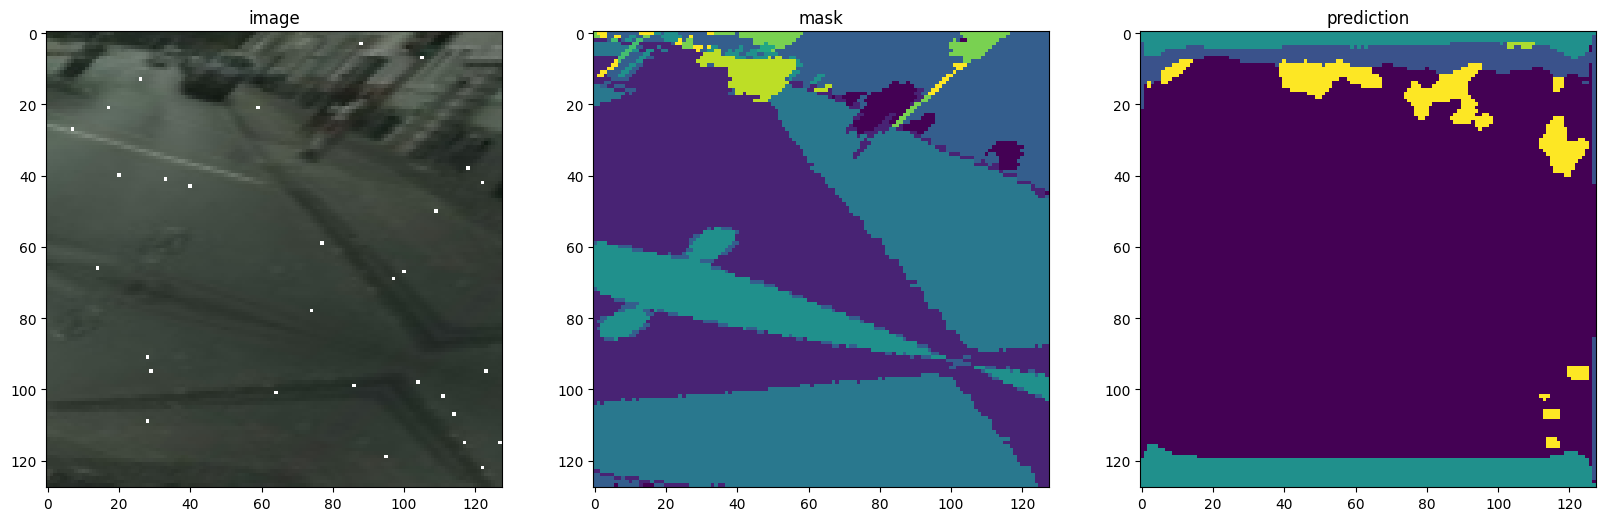

 33%|███▎      | 1/3 [01:50<03:41, 110.68s/it]

[Epochs-1/3]:
[Train_loss:1.5923 | Train_acc:0.1265 | Val_loss:1.4521 | Val_acc:0.1496]
--------------------
Validation results after 2 epochs:


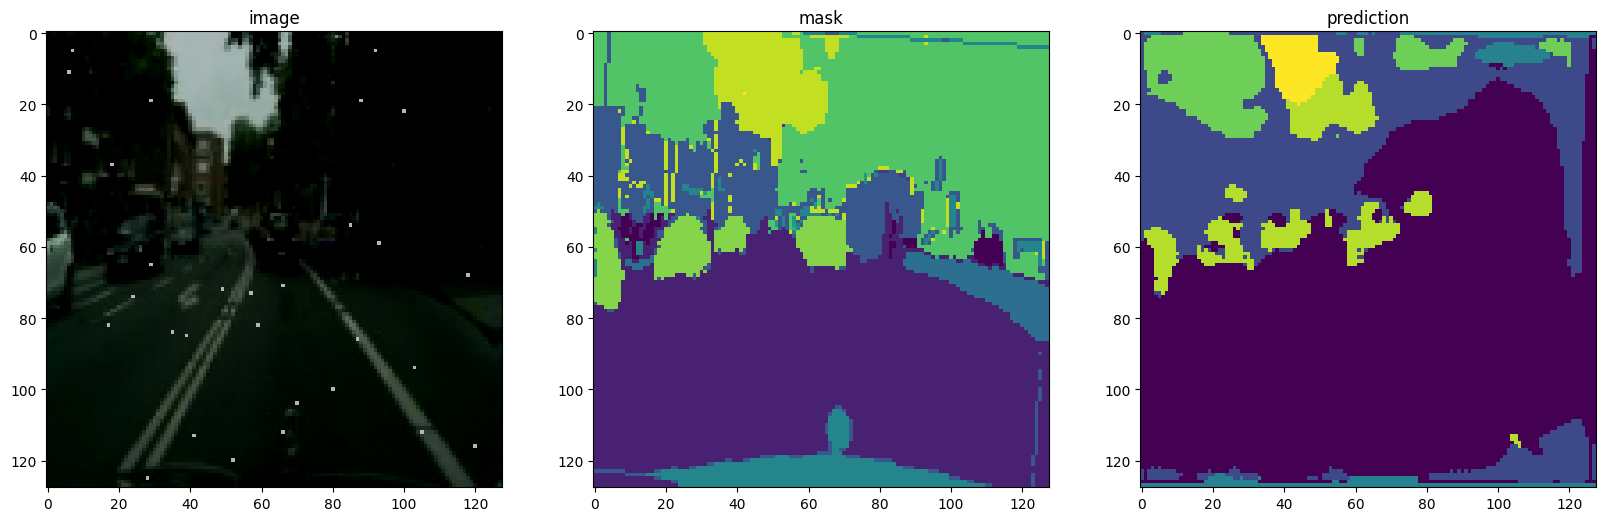

 67%|██████▋   | 2/3 [03:34<01:46, 106.56s/it]

[Epochs-2/3]:
[Train_loss:1.2549 | Train_acc:0.1981 | Val_loss:1.5903 | Val_acc:0.1270]
--------------------
Validation results after 3 epochs:


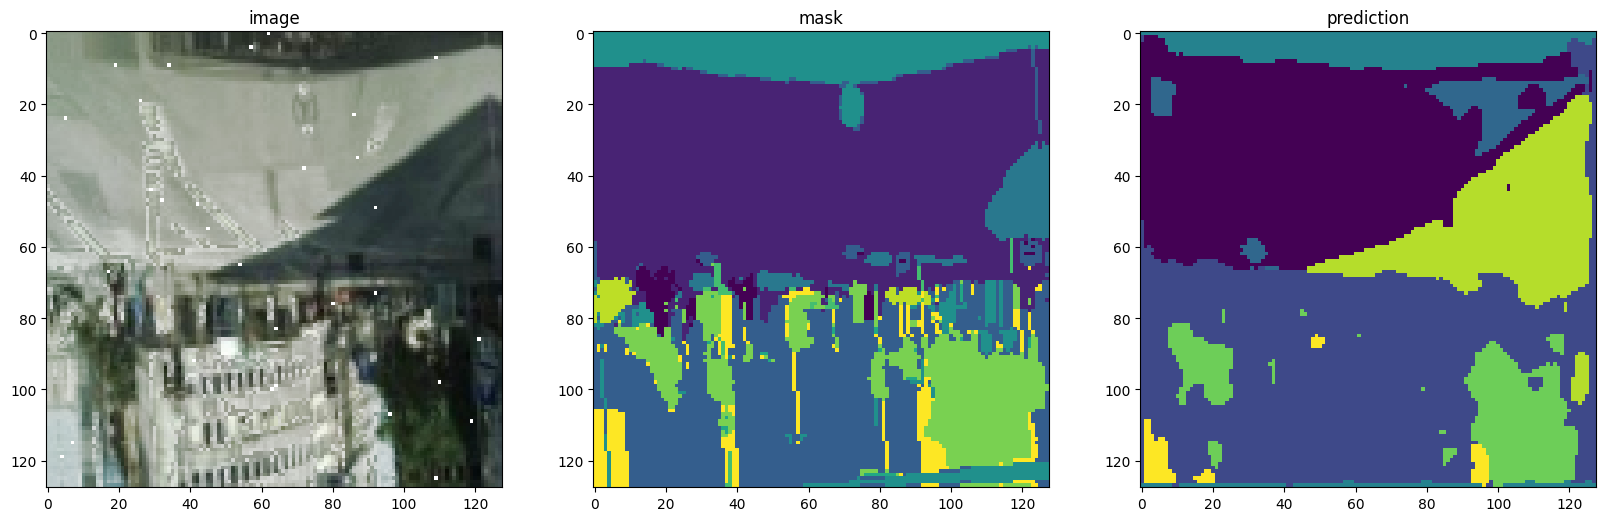

100%|██████████| 3/3 [05:16<00:00, 105.44s/it]

[Epochs-3/3]:
[Train_loss:1.2182 | Train_acc:0.2075 | Val_loss:471500.8084 | Val_acc:0.2070]


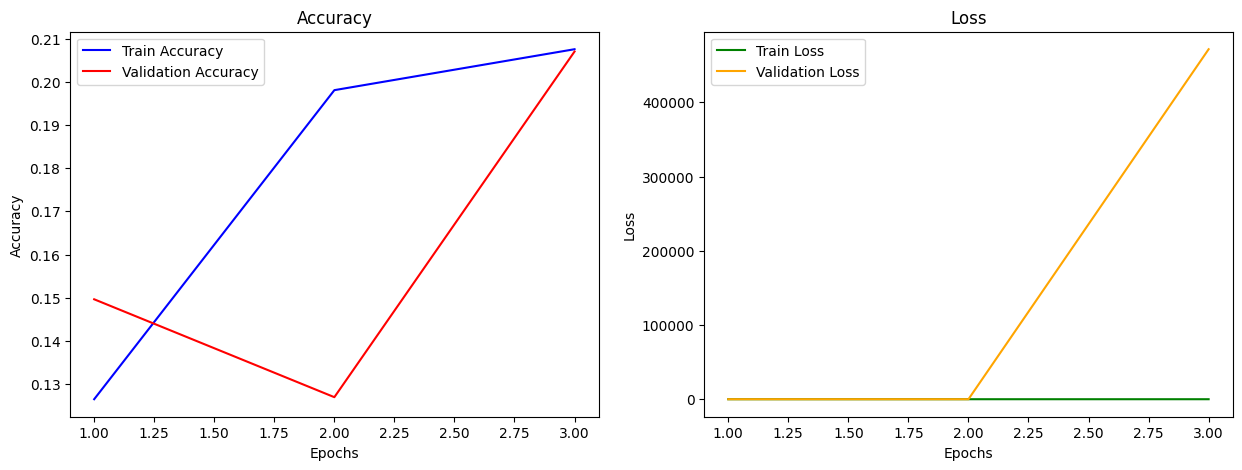

In [ ]:
trainer.train()

## Defining Improved Model

### Initializing

### Training Improved Model

## Comparative Analysis

## Streamlit Deployment